In [1]:
!pip install pydub

In [2]:
!pip install SpeechRecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 37.7 MB/s eta 0:00:00


In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
import cv2
import librosa
import matplotlib.pyplot as plt
import os

from moviepy.editor import VideoFileClip
from pydub import AudioSegment
import io

from scipy.io.wavfile import write

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

In [41]:
# GPU configuration
import warnings
warnings.filterwarnings("ignore")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("GPU is available")
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1
GPU is available


In [42]:
def remove_wav_files(directory):
    """
    Recursively removes all .wav files in the given directory and its subdirectories.

    Args:
    directory (str): The path to the main directory where the search should begin.
    """
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)
                    print(f"Removed: {file_path}")
                except OSError as e:
                    print(f"Error removing {file_path}: {e}")

In [43]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [44]:
dataset_directory = "/content/gdrive/My Drive/Colab Notebooks/cropped_lips"  # Path to the main directory
remove_wav_files(dataset_directory)

In [45]:
warnings.filterwarnings('ignore')

In [46]:
my_num_frames=10
my_duration=10

In [47]:
# Define function to extract video frames using OpenCV
def preprocess_video(video_data, num_frames=my_num_frames):
    frames = []
    cap = cv2.VideoCapture(video_data)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=np.int32)

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (112, 112))  # Reduced resolution
            frames.append(frame)
    cap.release()

    if len(frames) > num_frames:
        frames = frames[:num_frames]
    else:
        padding = [np.zeros((112, 112, 3), dtype=np.uint8)] * (num_frames - len(frames))
        frames.extend(padding)

    return frames

In [48]:
def extract_audio_features(video_data, sample_rate=22050, num_mels=128, duration=my_duration):
    y, sr = librosa.load(video_data, sr=sample_rate, duration=duration)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=num_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Pad or truncate the features to a fixed length (e.g., 128)
    max_length = 128
    if mel_spectrogram_db.shape[1] < max_length:
        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, max_length - mel_spectrogram_db.shape[1])), mode='constant')
    elif mel_spectrogram_db.shape[1] > max_length:
        mel_spectrogram_db = mel_spectrogram_db[:, :max_length]

    return mel_spectrogram_db

In [49]:
def preprocess_dataset(data_dir, num_frames=my_num_frames, sample_rate=22050, num_mels=128, duration=my_duration):
    video_frames = []
    audio_features = []
    labels = []

    classes = os.listdir(data_dir)
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print(class_dir)
        if not os.path.isdir(class_dir):
            continue
        for video_file in os.listdir(class_dir):
            video_path = os.path.join(class_dir, video_file)
            frames = preprocess_video(video_path, num_frames=num_frames)
            audio_feat = extract_audio_features(video_path, sample_rate=sample_rate, num_mels=num_mels, duration=duration)
            video_frames.append(frames)
            audio_features.append(audio_feat)
            labels.append(class_idx)

    return np.array(video_frames), np.array(audio_features), np.array(labels)

In [50]:
def preprocess_audio_dataset(data_dir, sample_rate=22050, num_mels=128, duration=my_duration):
    audio_features = []
    labels = []

    classes = os.listdir(data_dir)
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print(class_dir)
        if not os.path.isdir(class_dir):
            continue
        for video_file in os.listdir(class_dir):
            video_path = os.path.join(class_dir, video_file)
            audio_feat = extract_audio_features(video_path, sample_rate=sample_rate, num_mels=num_mels, duration=duration)
            audio_features.append(audio_feat)
            labels.append(class_idx)

    return np.array(audio_features), np.array(labels)

In [51]:
# Check if the features are already saved in the CSV file
csv_file = '/content/gdrive/My Drive/Colab Notebooks/voice_features_cropped.csv'
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
    audio_features = np.array(df['features'].apply(eval).tolist())  # Convert list back to numpy array
    labels = np.array(df['labels'].tolist())
else:
    # Dataset path
    data_dir = "/content/gdrive/My Drive/Colab Notebooks/cropped_lips"
    extracted_features = []
    # Preprocess the dataset
    video_frames, audio_features, labels = preprocess_dataset(data_dir, num_frames=my_num_frames, duration=my_duration)
    # Save the extracted features to the CSV file
    df = pd.DataFrame({
        'features': [feat.tolist() for feat in audio_features],  # Convert numpy arrays to lists for serialization
        'labels': labels
    })
    df.to_csv(csv_file, index=False)

/content/gdrive/My Drive/Colab Notebooks/cropped_lips/AlessandroQ
/content/gdrive/My Drive/Colab Notebooks/cropped_lips/Andrea
/content/gdrive/My Drive/Colab Notebooks/cropped_lips/Cantarella
/content/gdrive/My Drive/Colab Notebooks/cropped_lips/Albert
/content/gdrive/My Drive/Colab Notebooks/cropped_lips/Alex
/content/gdrive/My Drive/Colab Notebooks/cropped_lips/AndreaG
/content/gdrive/My Drive/Colab Notebooks/cropped_lips/Adriano
/content/gdrive/My Drive/Colab Notebooks/cropped_lips/Alessandra
/content/gdrive/My Drive/Colab Notebooks/cropped_lips/AlessandroS
/content/gdrive/My Drive/Colab Notebooks/cropped_lips/Carlo
/content/gdrive/My Drive/Colab Notebooks/cropped_lips/Gabriele
/content/gdrive/My Drive/Colab Notebooks/cropped_lips/FrancescoG
/content/gdrive/My Drive/Colab Notebooks/cropped_lips/Fabio
/content/gdrive/My Drive/Colab Notebooks/cropped_lips/Ernesto
/content/gdrive/My Drive/Colab Notebooks/cropped_lips/Francesca
/content/gdrive/My Drive/Colab Notebooks/cropped_lips/Crist

In [52]:
# Define custom node activation layer
class MMNActivation(layers.Layer):
    def __init__(self, num_nodes=10, **kwargs):
        super(MMNActivation, self).__init__(**kwargs)
        self.num_nodes = num_nodes

    def build(self, input_shape):
        self.nodes_weights = self.add_weight(shape=(input_shape[-1], self.num_nodes),
                                               initializer='glorot_uniform',
                                               trainable=True,
                                               name='nodes_weights')
        self.nodes_bias = self.add_weight(shape=(self.num_nodes,),
                                             initializer='zeros',
                                             trainable=True,
                                             name='nodes_bias')

    def call(self, inputs):
        # Assuming inputs are of shape (batch_size, num_features)
        activation = tf.matmul(inputs, self.nodes_weights) + self.nodes_bias
        return activation

In [53]:
def create_mmn_network(input_shape, num_nodes=10):
    video_input = layers.Input(shape=input_shape['video'])
    audio_input = layers.Input(shape=input_shape['audio'])

    video_features = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(video_input)
    video_features = layers.MaxPooling3D(pool_size=(2, 2, 2))(video_features)
    video_features = layers.Flatten()(video_features)

    audio_features = layers.Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.01))(audio_input)
    audio_features = layers.MaxPooling1D(pool_size=2)(audio_features)
    audio_features = layers.Flatten()(audio_features)

    video_features = MMNActivation(num_nodes=num_nodes)(video_features)
    audio_features = MMNActivation(num_nodes=num_nodes)(audio_features)

    concatenated_features = layers.Concatenate()([video_features, audio_features])

    dense_layer = layers.Dense(128)(concatenated_features)
    output_layer = layers.Dense(43, activation='softmax')(dense_layer)

    model = models.Model(inputs=[video_input, audio_input], outputs=output_layer)
    return model

In [54]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
    train_video, train_audio = X_train
    val_video, val_audio = X_val
    # Assuming train_video and val_video are lists of video frames
    train_video_features = np.array(train_video).astype(np.float32) / 255.0
    val_video_features = np.array(val_video).astype(np.float32) / 255.0
    train_audio = np.array(train_audio).astype(np.float32)
    val_audio = np.array(val_audio).astype(np.float32)
    history = model.fit([train_video_features, train_audio], np.array(y_train),
                        validation_data=([val_video_features, val_audio], np.array(y_val)),
                        epochs=epochs, batch_size=batch_size)
    return history


In [55]:
def test_model(model, X_test, y_test):
    test_video, test_audio = X_test
    # Assuming test_video and test_audio are already preprocessed arrays
    test_video_features = np.array(test_video).astype(np.float32) / 255.0
    test_audio = np.array(test_audio).astype(np.float32)
    loss, accuracy = model.evaluate([test_video_features, test_audio], np.array(y_test))
    print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

In [56]:
# Define function to plot loss and accuracy
def plot_metrics(history):
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(12, 6))
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.tight_layout()
    plt.savefig('/content/gdrive/My Drive/Colab Notebooks/results/mmn_loss_accuracy_cropped.png')
    plt.show()

In [57]:
# Ensure the number of samples is consistent
num_samples = min(len(video_frames), len(audio_features), len(labels))
video_frames = video_frames[:num_samples]
audio_features = audio_features[:num_samples]
labels = labels[:num_samples]

In [58]:
# Split the data into train, validation, and test sets
X_train_frames, X_test_frames, X_train_audio, X_test_audio, y_train, y_test = train_test_split(video_frames, audio_features, labels, test_size=0.2, stratify=labels)
X_train_frames, X_val_frames, X_train_audio, X_val_audio, y_train, y_val = train_test_split(X_train_frames, X_train_audio, y_train, test_size=0.2, stratify=None)

In [59]:
# Combine the split parts
X_train = [X_train_frames, X_train_audio]
X_val = [X_val_frames, X_val_audio]
X_test = [X_test_frames, X_test_audio]

In [60]:
input_shape = {'video': (my_num_frames, 112, 112, 3), 'audio': (128, 128)}

In [61]:
# Define a custom learning rate
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001  # You can experiment with values like 0.01, 0.0001, etc.
optimizer = Adam(learning_rate=0.001)

In [62]:
from tensorflow.keras.regularizers import l2
from scipy.interpolate import BSpline

# Create and compile the model
with tf.device('/GPU:0'):
    model = create_mmn_network(input_shape, num_nodes=10)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 112, 112, 3)]    0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128)]           0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 8, 110, 110, 32)      2624      ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 126, 64)              24640     ['input_2[0][0]']             
                                                                                              

In [64]:
from keras.utils import to_categorical

# Assuming your targets are integer classes
y_train_encoded = to_categorical(y_train, num_classes=43)
y_val_encoded = to_categorical(y_val, num_classes=43)
y_test_encoded = to_categorical(y_test, num_classes=43)

tf.config.run_functions_eagerly(True)

In [65]:
# Now you can fit your model with the encoded targets
history = train_model(model, X_train, y_train_encoded, X_val, y_val_encoded, epochs=100)

Epoch 1/100
13/13 [==============================] - 8s 237ms/step - loss: 46.0294 - accuracy: 0.0240 - val_loss: 10.9643 - val_accuracy: 0.0577
Epoch 2/100
13/13 [==============================] - 2s 148ms/step - loss: 7.3576 - accuracy: 0.0361 - val_loss: 5.2039 - val_accuracy: 0.0769
Epoch 3/100
13/13 [==============================] - 2s 141ms/step - loss: 4.4932 - accuracy: 0.1226 - val_loss: 4.3968 - val_accuracy: 0.1635
Epoch 4/100
13/13 [==============================] - 2s 142ms/step - loss: 3.9543 - accuracy: 0.1971 - val_loss: 4.1302 - val_accuracy: 0.2212
Epoch 5/100
13/13 [==============================] - 2s 181ms/step - loss: 3.5561 - accuracy: 0.3077 - val_loss: 3.7368 - val_accuracy: 0.3269
Epoch 6/100
13/13 [==============================] - 3s 204ms/step - loss: 3.1079 - accuracy: 0.4111 - val_loss: 3.4761 - val_accuracy: 0.3654
Epoch 7/100
13/13 [==============================] - 2s 148ms/step - loss: 2.8001 - accuracy: 0.4952 - val_loss: 3.2789 - val_accuracy: 0.36

In [66]:
# Save the model
from tensorflow.keras.models import save_model
save_model(model, '/content/gdrive/My Drive/Colab Notebooks/results/mmn_model_cropped.h5')  # Save in format h5

In [67]:
# Save the model in TensorFlow Lite format with TF Select enabled
import tensorflow as tf

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Save the converted model to a file
tflite_model_path = '/content/gdrive/My Drive/Colab Notebooks/results/mmn_model_cropped.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [68]:
# Test the model
test_model(model, X_test, y_test_encoded)

5/5 [==============================] - 0s 86ms/step - loss: 0.7359 - accuracy: 0.9385
Test Loss: 0.7359150052070618, Test Accuracy: 0.9384615421295166


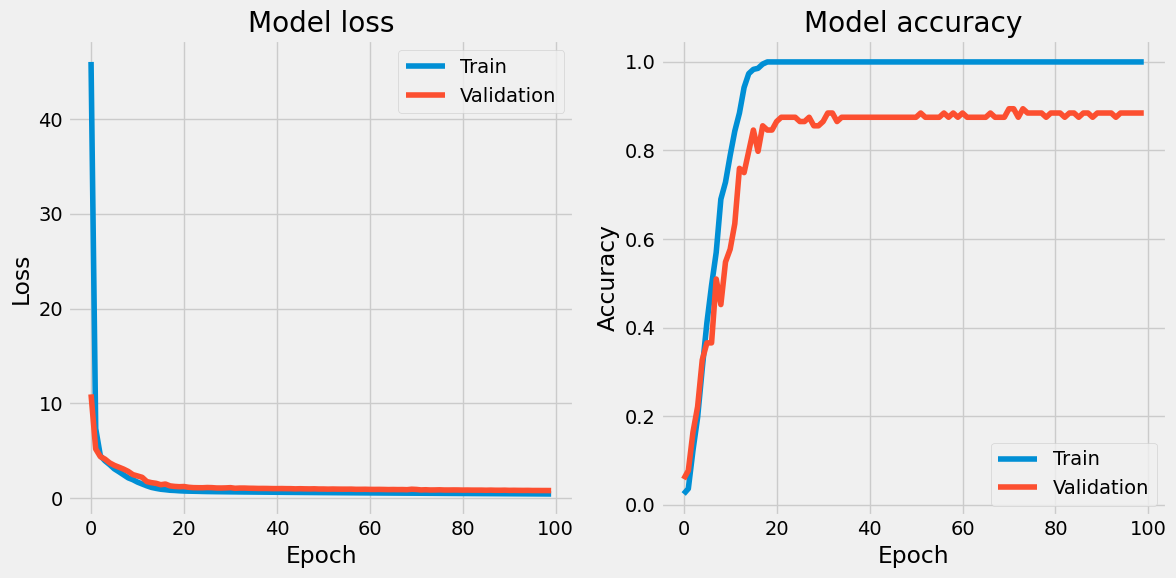

In [69]:
# Plot loss and accuracy
plot_metrics(history)

In [70]:
def predict_model(model, X_test):
    test_video, test_audio = X_test
    # Assuming test_video and test_audio are already preprocessed arrays
    test_video_features = np.array(test_video).astype(np.float32) / 255.0
    test_audio = np.array(test_audio).astype(np.float32)
    prediction = model.predict([test_video_features, test_audio])
    return prediction

In [71]:
# Make predictions using the model
predictions = predict_model(model, X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test_encoded, axis=1)

5/5 [==============================] - 0s 40ms/step


In [72]:
# Ensure your `classes` list matches the unique class labels
classes = ['Adriano', 'Albert', 'Alessandra', 'AlessandroQ', 'AlessandroS', 'Alex', 'Andrea', 'AndreaG', 'Cantarella', 'Carlo', 'Cristian', 'Davide', 'Edoardo', 'Emilio', 'Ernesto', 'Fabio', 'Francesca', 'FrancescoG', 'Gabriele', 'GabrieleG', 'GiuseppeV', 'Iris', 'Jacopo', 'Lorenzo', 'LorenzoC', 'Luca', 'Mansueto', 'MatteoM', 'Mattia', 'MattiaC', 'Paolo', 'Rachele', 'Sabrina', 'Simone', 'SimoneM', 'SimoneO', 'Siria', 'SiriaI', 'Solenne', 'Sophia', 'Stefano', 'StefanoM', 'Vincenzo']
# Ensure the number of unique labels matches the number of classes
unique_labels = np.unique(true_labels)
if len(unique_labels) != len(classes):
    print(f"Warning: Number of unique labels ({len(unique_labels)}) does not match number of classes ({len(classes)})")

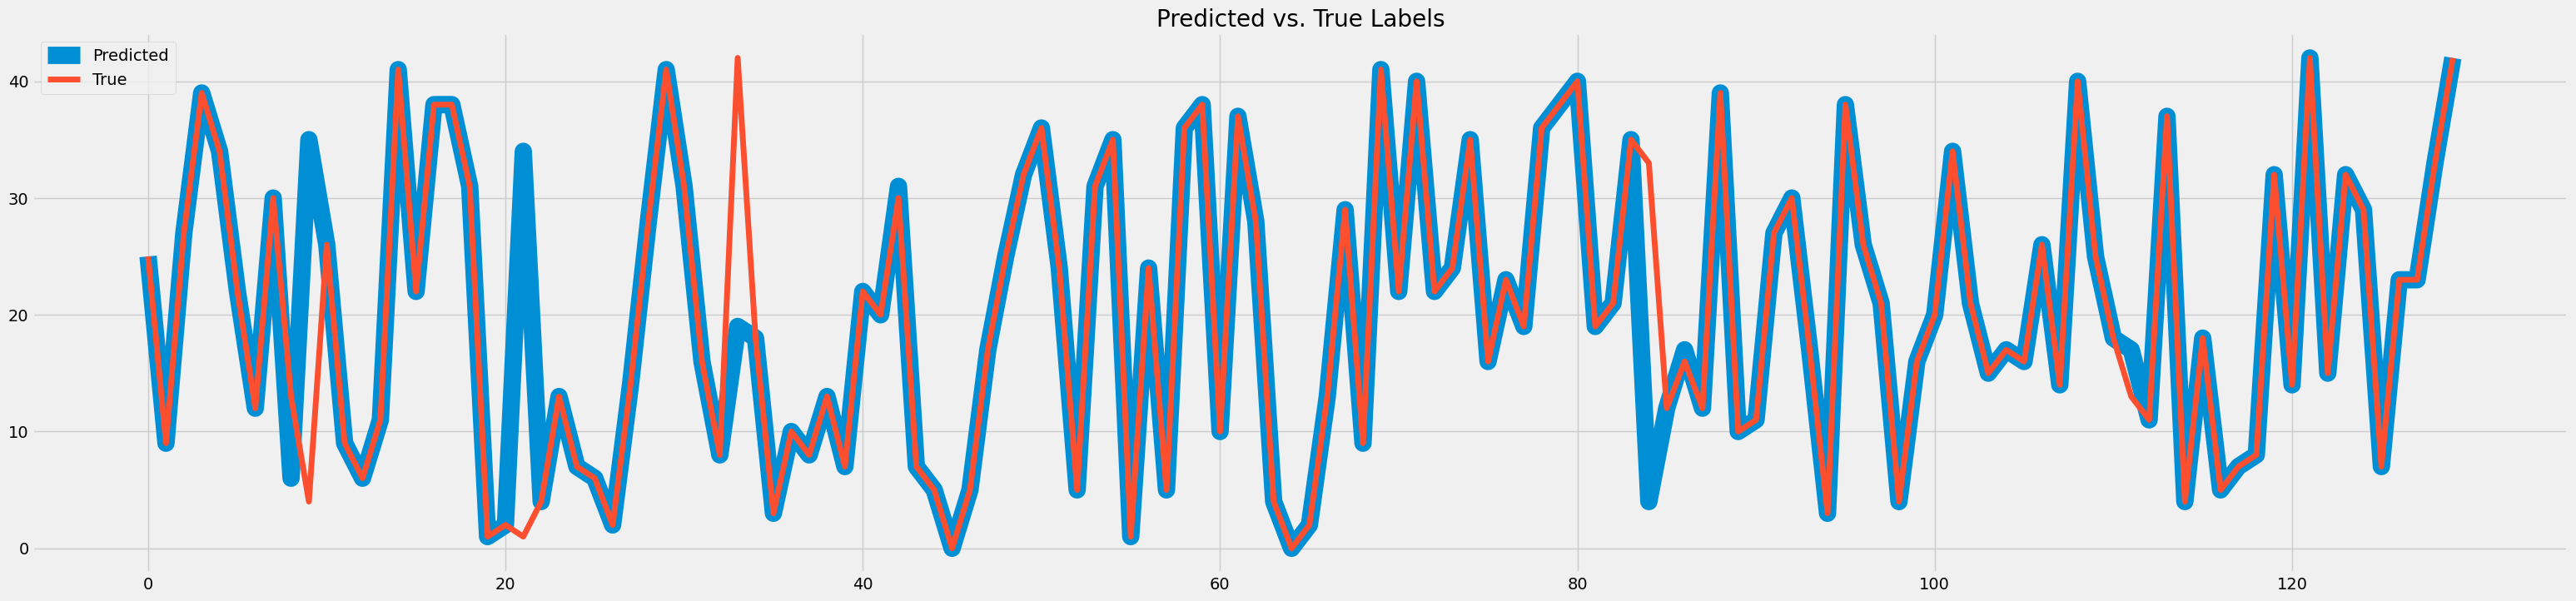

In [73]:
# Create a bar plot to visualize predicted vs. true labels
plt.style.use("fivethirtyeight")
plt.figure(figsize=(35, 8))
plt.plot(predicted_labels, label='Predicted', linewidth = '15.0')
plt.plot(true_labels, label='True', linewidth = '5.0')
plt.title('Predicted vs. True Labels')
plt.legend()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/results/inference_curve_cropped.png')
plt.show()

In [74]:
#import sklearn.metrics.confusion_matrix
import sklearn

# Calculate the confusion matrix
conf_matrix = sklearn.metrics.confusion_matrix(true_labels, predicted_labels)

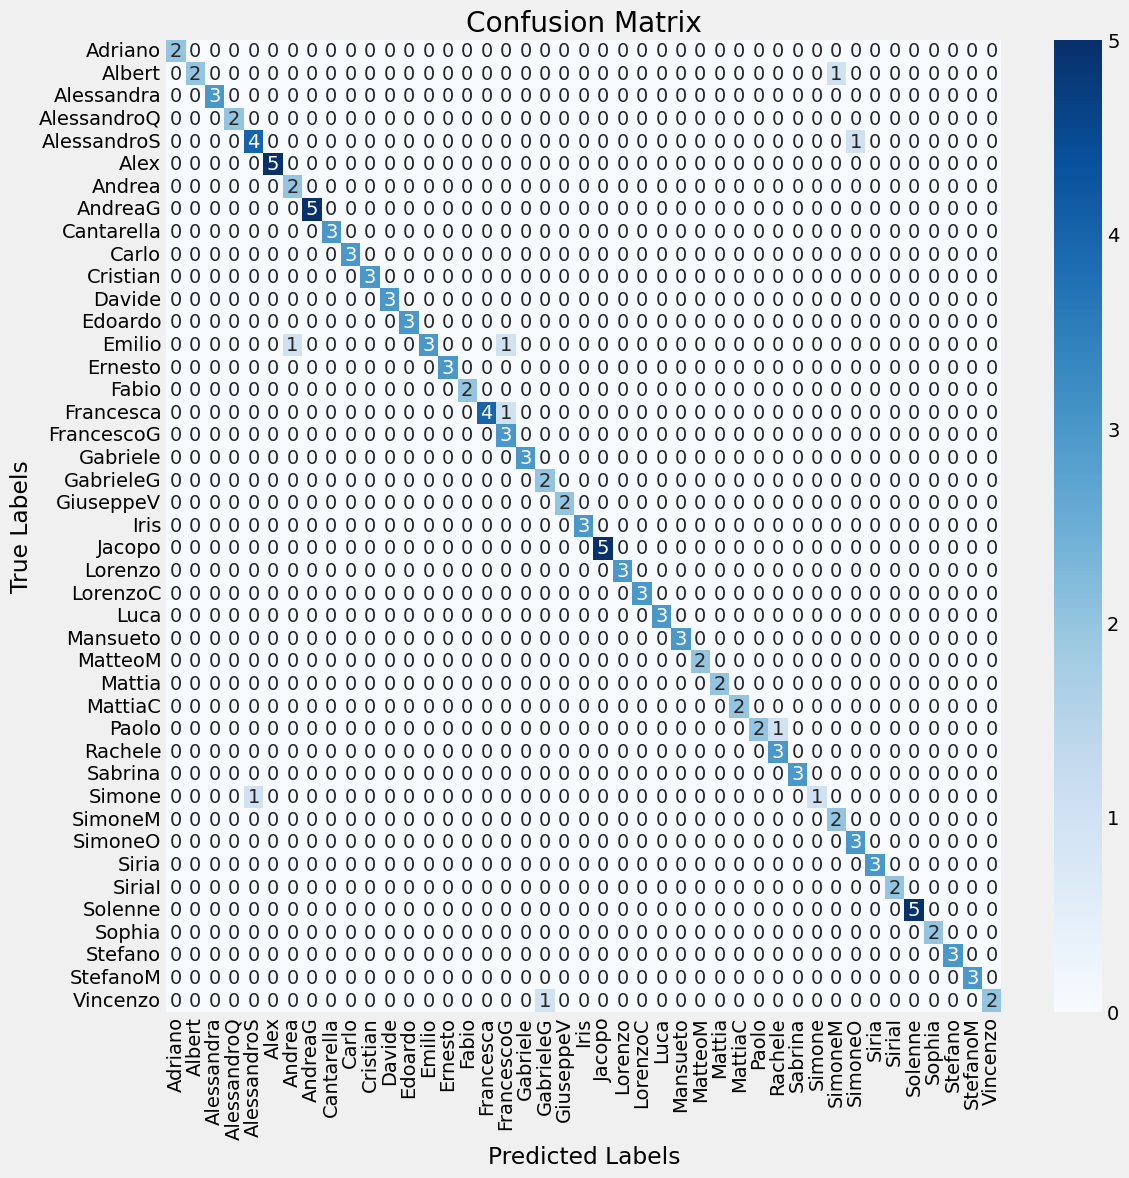

In [75]:
import seaborn as sns

# Plot the confusion matrix
plt.style.use("fivethirtyeight")
y_true = true_labels
y_pred = predicted_labels
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/results/confusion_matrix_cropped.png')
plt.show()

In [76]:
# Create a heatmap-style plot for classification report metrics
def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-5]:
        row = line.split()
        report_data.append(row)

    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(np.array(report_data)[:, 1:].astype(float), annot=True, cmap='Blues', fmt='f', xticklabels=['precision', 'recall', 'f1-score', 'support'], yticklabels=classes)
    #sns.heatmap(np.array(report_data)[:, 1:].astype(float), annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=np.array(report_data)[:, 0])
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.title("Classification Report")
    plt.savefig('/content/gdrive/My Drive/Colab Notebooks/results/classification_cropped.png')
    plt.show()

In [77]:
from sklearn.metrics import classification_report

# Calculate and print classification report
report = classification_report(true_labels, predicted_labels, target_names=classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Adriano       1.00      1.00      1.00         2
      Albert       1.00      0.67      0.80         3
  Alessandra       1.00      1.00      1.00         3
 AlessandroQ       1.00      1.00      1.00         2
 AlessandroS       0.80      0.80      0.80         5
        Alex       1.00      1.00      1.00         5
      Andrea       0.67      1.00      0.80         2
     AndreaG       1.00      1.00      1.00         5
  Cantarella       1.00      1.00      1.00         3
       Carlo       1.00      1.00      1.00         3
    Cristian       1.00      1.00      1.00         3
      Davide       1.00      1.00      1.00         3
     Edoardo       1.00      1.00      1.00         3
      Emilio       1.00      0.60      0.75         5
     Ernesto       1.00      1.00      1.00         3
       Fabio       1.00      1.00      1.00         2
   Francesca       1.00      0.80      0.89         5
  Fr

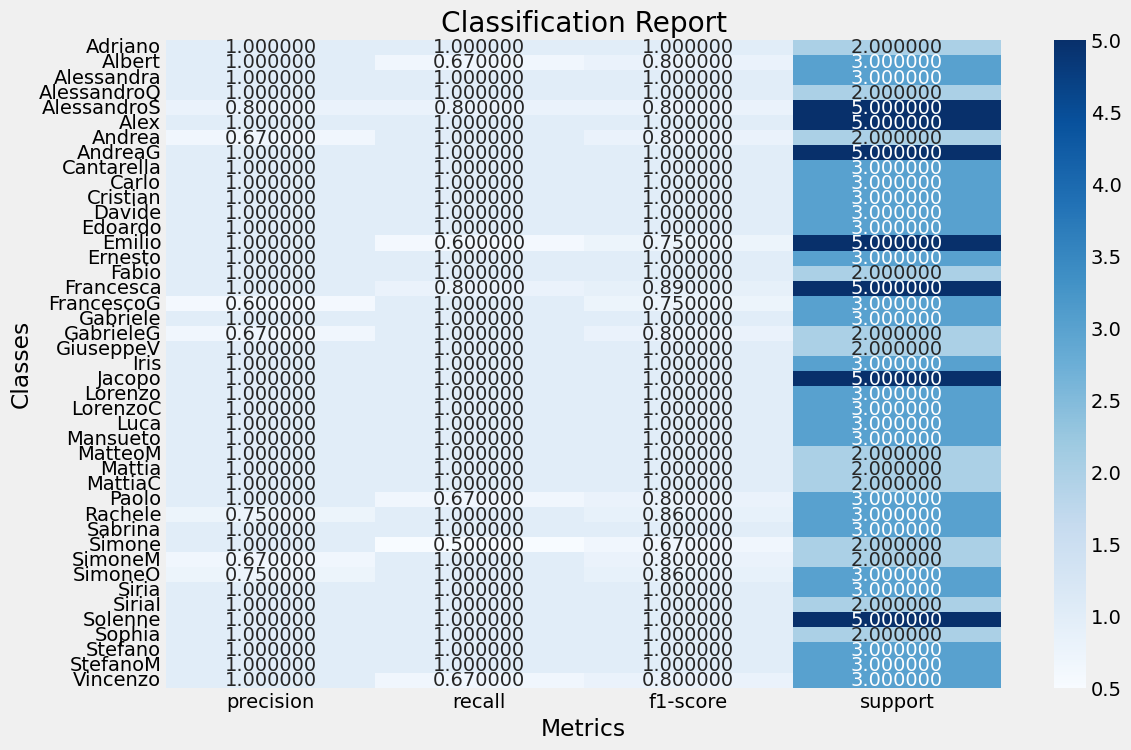

In [78]:
# Plot the classification report
plot_classification_report(report)

In [ ]:
## WORDS RECOGNITION

In [80]:
!pip install resampy
!pip install llvmlite
!pip install librosa
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.3 MB/s eta 0:00:00


In [44]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 111.1 MB/s eta 0:00:00
  

In [199]:
import pandas as pd
import os
import librosa as librs
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
import wave
import matplotlib.pylab as pyl
import soundfile as sf
import tensorflow as tf
import resampy
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Conv1D, Activation, BatchNormalization, SpatialDropout1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score


In [200]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


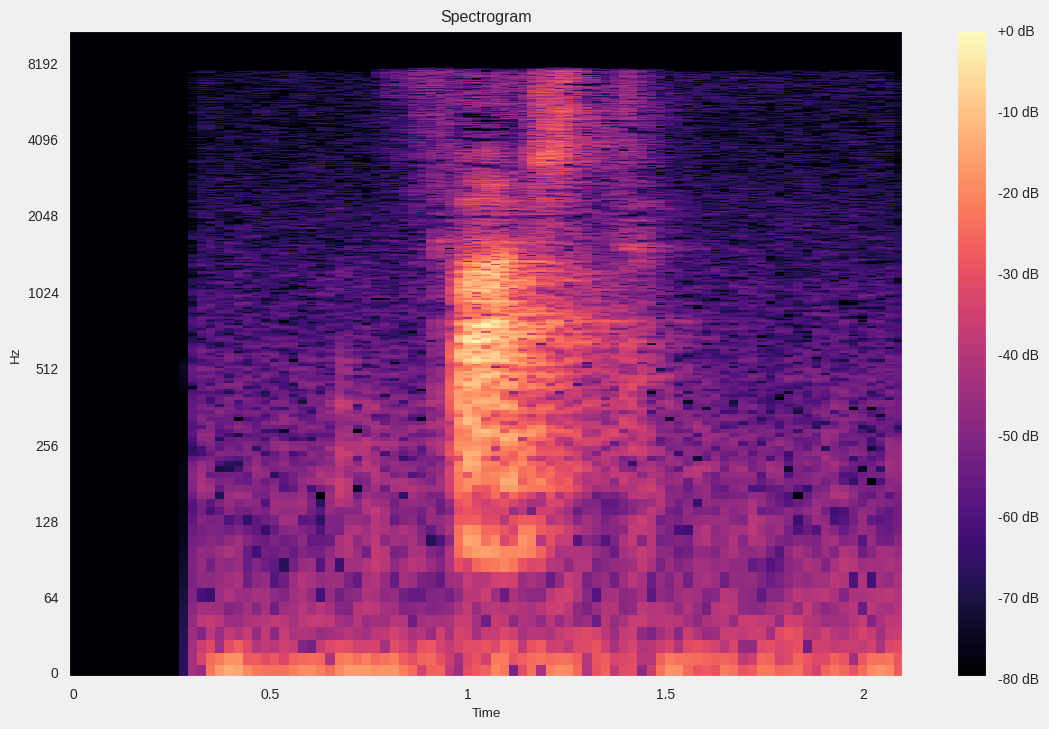

In [201]:
# Showing spectrogram
input_wav = "/content/gdrive/My Drive/Colab Notebooks/output/Adriano/VID_20240425_123157_FAST.wav"
y, sr = librs.load(input_wav)
# Compute the spectrogram
D = librs.amplitude_to_db(np.abs(librs.stft(y)), ref=np.max)
# Plot the spectrogram
plt.figure(figsize=(12, 8))
librs.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/results/spectrogram.png')
plt.show()

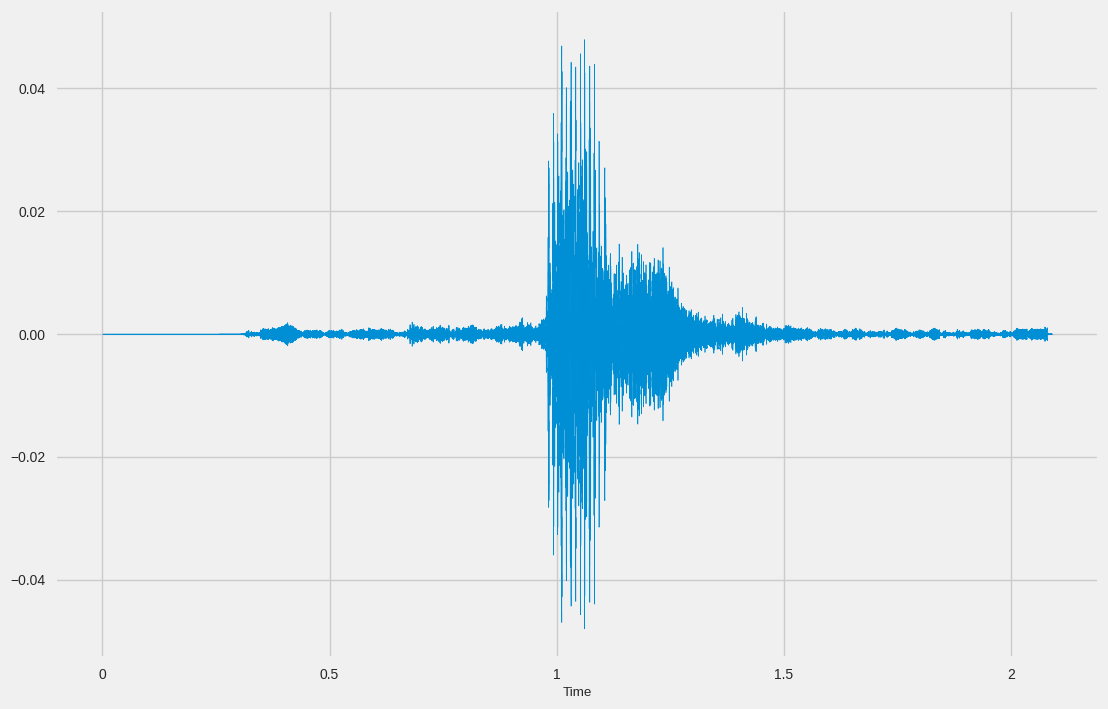

In [202]:
# Showing a splitted augmented wave of a click
file_name="/content/gdrive/My Drive/Colab Notebooks/output/Adriano/VID_20240425_123157_FAST.wav"
audio_data, sampling_rate = librs.load(file_name)
plt.figure(figsize=(12, 8))
librs.display.waveshow(audio_data,sr=sampling_rate)
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/results/single_audio_signal.png')

In [203]:
def extract_words_from_filenames(directory):
    words = set()

    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                basename = os.path.basename(file)
                word = basename.rsplit('_', 1)[-1].rsplit('.', 1)[0]
                words.add(word.lower())

    return words

def write_words_to_csv(words, output_csv):
    df = pd.DataFrame(words, columns=["word"])
    df.to_csv(output_csv, index=False)


def extract_and_write_words(directory, output_csv):
    words = extract_words_from_filenames(directory)
    write_words_to_csv(words, output_csv)

In [204]:
# Example usage
directory = "/content/gdrive/My Drive/Colab Notebooks/output"
output_csv = "/content/gdrive/My Drive/Colab Notebooks/allowed_words_cropped.csv"
extract_and_write_words(directory, output_csv)
print(f"Unique words have been written to {output_csv}")

Unique words have been written to /content/gdrive/My Drive/Colab Notebooks/allowed_words_cropped.csv


In [205]:
# Showing the fist lines of our csv file with the list of all augmented clicks
metadata = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/allowed_words_cropped.csv')
metadata.head(10)

,word
0,pillow
1,money
2,chiar
3,glasses
4,ginger
5,bottle
6,moon
7,cake
8,soft
9,yellow


In [206]:
metadata.count()

,0
word,90


In [207]:
def augment_audio(audio, sr):
    augmented_audios = []

    # Time stretching
    augmented_audios.append(librs.effects.time_stretch(audio, rate=0.8))
    augmented_audios.append(librs.effects.time_stretch(audio, rate=1.2))

    # Pitch shifting
    augmented_audios.append(librs.effects.pitch_shift(y=audio, sr=sr, n_steps=-2))
    augmented_audios.append(librs.effects.pitch_shift(y=audio, sr=sr, n_steps=2))

    # Adding noise
    noise = np.random.randn(len(audio))
    augmented_audios.append(audio + 0.005 * noise)

    return augmented_audios

def extract_audio_features(video_data, sample_rate=22050, num_mels=128, duration=10):
    y, sr = librs.load(video_data, sr=sample_rate, duration=duration)
    mel_spectrogram = librs.feature.melspectrogram(y=y, sr=sr, n_mels=num_mels)
    mel_spectrogram_db = librs.power_to_db(mel_spectrogram, ref=np.max)

    max_length = 128
    if mel_spectrogram_db.shape[1] < max_length:
        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, max_length - mel_spectrogram_db.shape[1])), mode='constant')
    elif mel_spectrogram_db.shape[1] > max_length:
        mel_spectrogram_db = mel_spectrogram_db[:, :max_length]

    return mel_spectrogram_db

In [208]:
# Corrected to include csv_file definition before use
csv_file = '/content/gdrive/My Drive/Colab Notebooks/words_features_cropped.csv'
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
    extracted_features = df.values.tolist()
else:
    extracted_features = []
    dataset_dir = '/content/gdrive/My Drive/Colab Notebooks/output'  # Specify your dataset directory
    for subdir, _, files in os.walk(dataset_dir):
        print(subdir)
        for file in files:
            if file.endswith('.wav'):
                file_name = os.path.join(subdir, file)
                expected_word = file.rsplit('_', 1)[-1].rsplit('.', 1)[0].lower()
                data = extract_audio_features(file_name)
                extracted_features.append([data, expected_word])

                # Apply data augmentation
                y, sr = librs.load(file_name, sr=None)
                augmented_audios = augment_audio(y, sr)
                for augmented_audio in augmented_audios:
                    mel_spectrogram = librs.feature.melspectrogram(y=augmented_audio, sr=sr, n_mels=128)
                    mel_spectrogram_db = librs.power_to_db(mel_spectrogram, ref=np.max)
                    max_length = 128
                    if mel_spectrogram_db.shape[1] < max_length:
                        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, max_length - mel_spectrogram_db.shape[1])), mode='constant')
                    elif mel_spectrogram_db.shape[1] > max_length:
                        mel_spectrogram_db = mel_spectrogram_db[:, :max_length]
                    extracted_features.append([mel_spectrogram_db, expected_word])

    # Save the extracted features to the CSV file
    df = pd.DataFrame(extracted_features, columns=['features', 'word'])
    df.to_csv(csv_file, index=False)

In [193]:
import pandas as pd
import numpy as np
from pycaret.classification import setup, compare_models, pull, save_model
import tensorflow as tf
import ast

# Function to safely convert list-like strings back to a numpy array
def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        #print(f"Error parsing: {x}")
        return None

# Load dataset
csv_file = '/content/gdrive/My Drive/Colab Notebooks/words_features_cropped.csv'
df = pd.read_csv(csv_file)

# Apply safe_literal_eval to the 'features' column
#df['features'] = df['features'].apply(safe_literal_eval)
# Inspect the first few entries to understand the data format
print(df.head(10))

# Filter out rows where 'features' could not be parsed
df = df[df['features'].notnull()]

# Convert the 'features' column to a numpy array
X = np.array(df['features'].tolist())
y = df['word']

print(len(X))
# Ensure that the features are correctly shaped
if len(X) > 0:
    num_samples, *rest = X.shape
    num_features = int(np.prod(rest))
    print("Number of samples:", num_samples)
    print("Number of features per sample:", num_features)
    X_flattened = X.reshape(num_samples, num_features)

    # Create a DataFrame suitable for PyCaret
    df_features = pd.DataFrame(X_flattened)
    df_labels = pd.DataFrame(y, columns=['word'])
    data = pd.concat([df_features, df_labels], axis=1)

    # Set up PyCaret
    clf_setup = setup(data, target='word', session_id=123, verbose=False)

    # Train the model
    with tf.device('/GPU:0'):
        # Compare models
        models_to_compare = ['lr', 'knn', 'nb', 'dt', 'svm', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'lda', 'et']
        best_model = compare_models(include=models_to_compare)

# Display model comparison results
results = pull()
print(results)

# Save the model comparison results to a CSV file
results.to_csv('/content/gdrive/My Drive/Colab Notebooks/results/words_model_metric_cropped.csv', index=False)

# Save the best model
save_model(best_model, 'best_model_words_cropped')

                                            features    word
0  [[-80. -80. -80. ...   0.   0.   0.]\n [-80. -...  google
1  [[-80. -80. -80. ...   0.   0.   0.]\n [-80. -...  google
2  [[-80. -80. -80. ...   0.   0.   0.]\n [-80. -...  google
3  [[-80. -80. -80. ...   0.   0.   0.]\n [-80. -...  google
4  [[-80. -80. -80. ...   0.   0.   0.]\n [-80. -...  google
5  [[-41.06519874 -37.30150869 -40.24347572 ...  ...  google
6  [[-80. -80. -80. ...   0.   0.   0.]\n [-80. -...  google
7  [[-80. -80. -80. ...   0.   0.   0.]\n [-80. -...  google
8  [[-80. -80. -80. ...   0.   0.   0.]\n [-80. -...  google
9  [[-80. -80. -80. ...   0.   0.   0.]\n [-80. -...  google
3042
Number of samples: 3042
Number of features per sample: 1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
mlp,MLP Classifier,0.0808,0.0000,0.0808,0.0065,0.0121,0.0000,0.0000,0.3950
ada,Ada Boost Classifier,0.0808,0.0000,0.0808,0.0065,0.0121,0.0000,0.0000,0.2620
dt,Decision Tree Classifier,0.0719,0.0000,0.0719,0.0083,0.0148,0.0201,0.0287,0.0440
rf,Random Forest Classifier,0.0719,0.0000,0.0719,0.0083,0.0148,0.0201,0.0287,0.3940
et,Extra Trees Classifier,0.0719,0.0000,0.0719,0.0083,0.0148,0.0201,0.0287,0.2050
ridge,Ridge Classifier,0.0648,0.0000,0.0648,0.0087,0.0152,-0.0114,-0.0156,0.0790
lda,Linear Discriminant Analysis,0.0611,0.0000,0.0611,0.0087,0.0152,-0.0207,-0.0287,0.0500
lr,Logistic Regression,0.0611,0.0000,0.0611,0.0087,0.0152,-0.0207,-0.0287,4.3450
svm,SVM - Linear Kernel,0.0333,0.0000,0.0333,0.0022,0.0041,0.0009,0.0013,0.5030
knn,K Neighbors Classifier,0.0225,0.0000,0.0225,0.0016,0.0029,0.0064,0.0093,0.0680


Processing:   0%|          | 0/53 [00:00<?, ?it/s]

                                 Model  Accuracy  AUC  Recall   Prec.      F1  \
mlp                     MLP Classifier    0.0808  0.0  0.0808  0.0065  0.0121   
ada               Ada Boost Classifier    0.0808  0.0  0.0808  0.0065  0.0121   
dt            Decision Tree Classifier    0.0719  0.0  0.0719  0.0083  0.0148   
rf            Random Forest Classifier    0.0719  0.0  0.0719  0.0083  0.0148   
et              Extra Trees Classifier    0.0719  0.0  0.0719  0.0083  0.0148   
ridge                 Ridge Classifier    0.0648  0.0  0.0648  0.0087  0.0152   
lda       Linear Discriminant Analysis    0.0611  0.0  0.0611  0.0087  0.0152   
lr                 Logistic Regression    0.0611  0.0  0.0611  0.0087  0.0152   
svm                SVM - Linear Kernel    0.0333  0.0  0.0333  0.0022  0.0041   
knn             K Neighbors Classifier    0.0225  0.0  0.0225  0.0016  0.0029   
nb                         Naive Bayes    0.0113  0.0  0.0113  0.0019  0.0032   
qda    Quadratic Discriminan

(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None, include=[],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('...
                                batch_size='auto', beta_1=0.9, beta_2=0.999,
                                early_stopping=False, epsilon=1e-08,
     

In [194]:
# Save the model comparison results to a CSV file
results.to_csv('/content/gdrive/My Drive/Colab Notebooks/results/words_model_metric_cropped.csv', index=False)

In [209]:
# Create DataFrame
extracted_features_df = pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head(10)

,feature,class
0,[[-80. -80. -80. ... 0. 0. 0.]\n [-80. -...,google
1,[[-80. -80. -80. ... 0. 0. 0.]\n [-80. -...,google
2,[[-80. -80. -80. ... 0. 0. 0.]\n [-80. -...,google
3,[[-80. -80. -80. ... 0. 0. 0.]\n [-80. -...,google
4,[[-80. -80. -80. ... 0. 0. 0.]\n [-80. -...,google
5,[[-41.06519874 -37.30150869 -40.24347572 ... ...,google
6,[[-80. -80. -80. ... 0. 0. 0.]\n [-80. -...,google
7,[[-80. -80. -80. ... 0. 0. 0.]\n [-80. -...,google
8,[[-80. -80. -80. ... 0. 0. 0.]\n [-80. -...,google
9,[[-80. -80. -80. ... 0. 0. 0.]\n [-80. -...,google


In [210]:
# Check class distribution
class_counts = extracted_features_df['class'].value_counts()
print("Class distribution after augmentation:", class_counts)

Class distribution after augmentation: class
google         246
mouse          240
apple          216
bed            150
pen            144
              ... 
pillow          12
ocean           12
chiar            6
230047apple      6
smarphone        6
Name: count, Length: 91, dtype: int64


In [211]:
# Prepare data for training
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [212]:
# Normalize the features
scaler = StandardScaler()
X = X.reshape(-1, X.shape[-1])
X = scaler.fit_transform(X)
X = X.reshape(-1, 128, 128)

ValueError: could not convert string to float: '[[-80. -80. -80. ...   0.   0.   0.]\n [-80. -80. -80. ...   0.   0.   0.]\n [-80. -80. -80. ...   0.   0.   0.]\n ...\n [-80. -80. -80. ...   0.   0.   0.]\n [-80. -80. -80. ...   0.   0.   0.]\n [-80. -80. -80. ...   0.   0.   0.]]'

In [181]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3, shuffle=True, stratify=y)
# Save the label encoder
import pickle
with open('/content/gdrive/My Drive/Colab Notebooks/results/labelencoder.pkl', 'wb') as f:
    pickle.dump(labelencoder, f)

In [182]:
# Define dataset variables for split in train and test
test_size=0.2
shuffle=True
stratify=None
random_state=3
# Define input shape and number of classes
input_dim = 1
num_classes = 63
kernel_size = 3
num_filters = 128
num_layers = 4
dropout_rate = 0.2
input_shape = (128, 128)  # Number of time steps and features
# Define a custom learning rate
learning_rate = 0.001
# Train the model
batch_size = 16
epochs = 100

In [104]:
#X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=shuffle, stratify=stratify)
num_labels = y.shape[1]
num_labels

91

In [105]:
# Model Building
def build_tcn(input_shape, num_classes, num_filters=128, kernel_size=3, num_layers=4, dropout_rate=0.2):
    inputs = Input(shape=input_shape)
    x = inputs  # The input tensor is already 3D, no need to expand dimensions

    for i in range(num_layers):
        dilation_rate = 2 ** i
        x = Conv1D(filters=num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [106]:
# Build and compile model
input_shape = (128, 128)
num_classes = y.shape[1]
tcn_model = build_tcn(input_shape, num_classes)
my_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
tcn_model.compile(optimizer=my_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [107]:
# Print model summary
tcn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128)]        0         
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 128)          49280     
                                                                 
 batch_normalization (Batch  (None, 128, 128)          512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128, 128)          0         
                                                                 
 spatial_dropout1d (Spatial  (None, 128, 128)          0         
 Dropout1D)                                                      
                                                                 
 conv1d_2 (Conv1D)           (None, 128, 128)          4928

In [108]:
from tensorflow.keras.utils import plot_model

# Plot the TCN model and save it as an image file
plot_model(tcn_model, to_file='/content/gdrive/My Drive/Colab Notebooks/results/tcn_model_cropped.png', show_shapes=True, show_layer_names=True)
print("TCN model architecture saved as 'tcn_model.png'")

TCN model architecture saved as 'tcn_model.png'


In [109]:
# Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/results/words_best_model_cropped.h5', monitor='val_loss', save_best_only=True)

In [110]:
# Train the model
with tf.device('/GPU:0'):
    history = tcn_model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])

Epoch 1/100
77/77 [==============================] - 14s 152ms/step - loss: 4.2191 - accuracy: 0.0760 - val_loss: 3.8762 - val_accuracy: 0.0870
Epoch 2/100
77/77 [==============================] - 11s 146ms/step - loss: 3.7273 - accuracy: 0.1352 - val_loss: 3.6326 - val_accuracy: 0.1494
Epoch 3/100
77/77 [==============================] - 12s 153ms/step - loss: 3.5843 - accuracy: 0.1480 - val_loss: 3.5109 - val_accuracy: 0.1576
Epoch 4/100
77/77 [==============================] - 12s 150ms/step - loss: 3.4752 - accuracy: 0.1558 - val_loss: 3.3948 - val_accuracy: 0.1839
Epoch 5/100
77/77 [==============================] - 21s 271ms/step - loss: 3.3649 - accuracy: 0.1652 - val_loss: 3.3428 - val_accuracy: 0.1757
Epoch 6/100
77/77 [==============================] - 24s 312ms/step - loss: 3.3023 - accuracy: 0.1800 - val_loss: 3.1901 - val_accuracy: 0.1987
Epoch 7/100
77/77 [==============================] - 18s 238ms/step - loss: 3.2342 - accuracy: 0.1841 - val_loss: 3.1338 - val_accuracy:

In [123]:
# Evaluate the model
loss, accuracy = tcn_model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

20/20 [==============================] - 1s 44ms/step - loss: 1.5260 - accuracy: 0.5764
Test accuracy: 57.64%


In [124]:
# Save the model
from tensorflow.keras.models import save_model

save_model(tcn_model, '/content/gdrive/My Drive/Colab Notebooks/results/tcn_model_new_cropped.h5')  # Save in format h5

In [125]:
# Evaluate the model on the training set
train_loss, train_accuracy = tcn_model.evaluate(X_train, y_train)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.4f}%")

77/77 [==============================] - 3s 37ms/step - loss: 0.7973 - accuracy: 0.8068
Train Loss: 0.7973, Train Accuracy: 80.6823%


In [126]:
# Evaluate the model
test_loss, test_accuracy = tcn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.4f}%")

20/20 [==============================] - 1s 32ms/step - loss: 1.5260 - accuracy: 0.5764
Test Loss: 1.5260, Test Accuracy: 57.6355%


In [127]:
predictions = tcn_model.predict(X_test)
true_labels = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded
predicted_labels = np.argmax(predictions, axis=1)

20/20 [==============================] - 0s 20ms/step


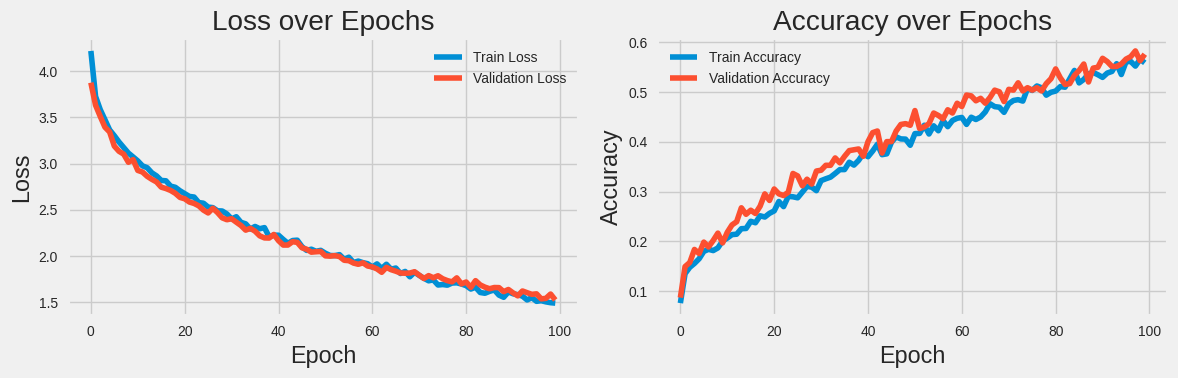

In [128]:
# Plot the loss and accuracy
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.tight_layout()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/results/loss_accuracy_words_cropped.png')
plt.show()

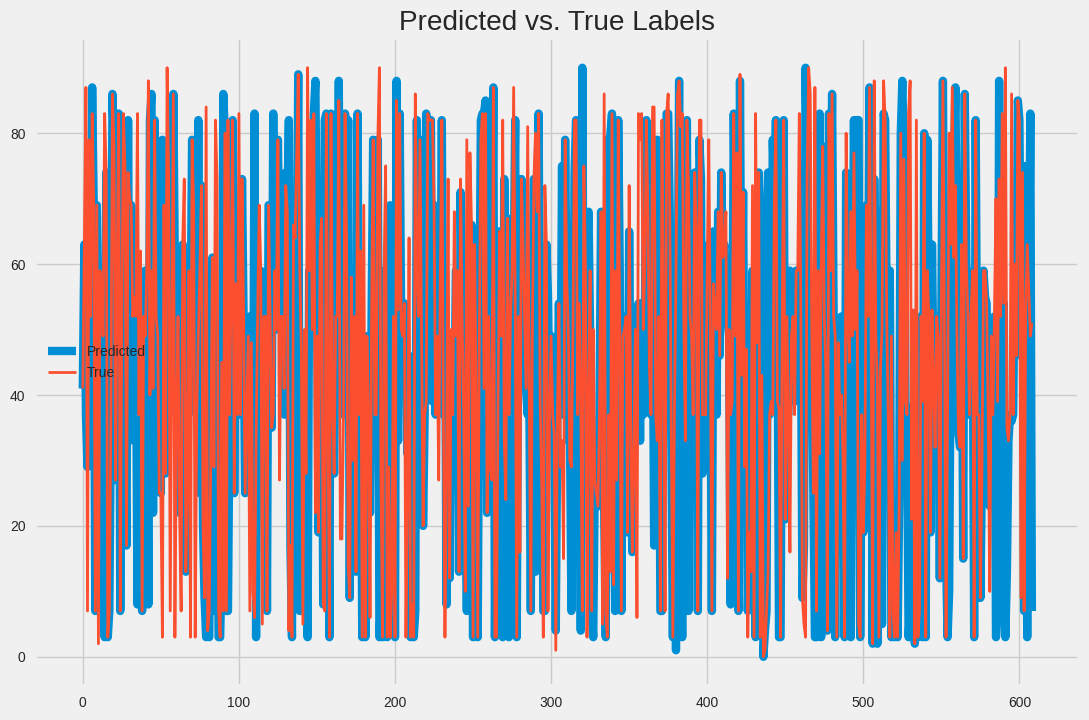

In [129]:
# Create a bar plot to visualize predicted vs. true labels
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 8))
plt.plot(predicted_labels, label='Predicted', linewidth = '6.0')
plt.plot(true_labels, label='True', linewidth = '2.0')
plt.title('Predicted vs. True Labels')
plt.legend()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/results/inference_curve_zoom_words_cropped.png')
plt.show()

In [130]:
def read_allowed_words(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    # Check if the expected column "words" exists in the DataFrame
    if 'word' not in df.columns:
        raise ValueError("The CSV file must contain a column named 'words'")
    # Convert the "words" column to a list
    words_list = df['word'].tolist()
    return words_list

In [131]:
# Example usage:
file_path = '/content/gdrive/My Drive/Colab Notebooks/allowed_words_cropped.csv'
allowed_words = read_allowed_words(file_path)
print(allowed_words)

['glass', 'day', 'water', 'plain', 'danger', 'witch', 'soft', 'after', 'room', 'overtake', 'paper', 'desktop', 'cup', 'yellow', 'password', 'clock', 'chair', 'light', 'smart', 'flag', 'jacket', 'green', 'money', 'spinner', 'bag', 'car', 'radioactivity', 'tower', 'sun', 'smarphone', 'medical', 'forest', 'glasses', 'inteliggence', 'chiar', 'computational', 'man', 'ginger', 'ball', 'lesson', 'coffe', 'smartphone', 'sugar', 'slow', 'stolen', 'shoes', 'hello', 'children', 'football', 'socks', 'pencilcase', 'apple', 'cybersecurity', 'pen', 'monitor', 'bed', 'cake', 'robotics', '230047apple', 'google', 'pizza', 'console', 'hat', 'white', 'window', 'smile', 'actor', 'instead', 'bottle', 'case', 'square', 'pillow', 'fast', 'pencil', 'book', 'beautiful', 'never', 'moon', 'good', 'dog', 'happy', 'music', 'ocean', 'pretty', 'wallet', 'fruit', 'mouse', 'sound', 'food', 'fluid', 'table']


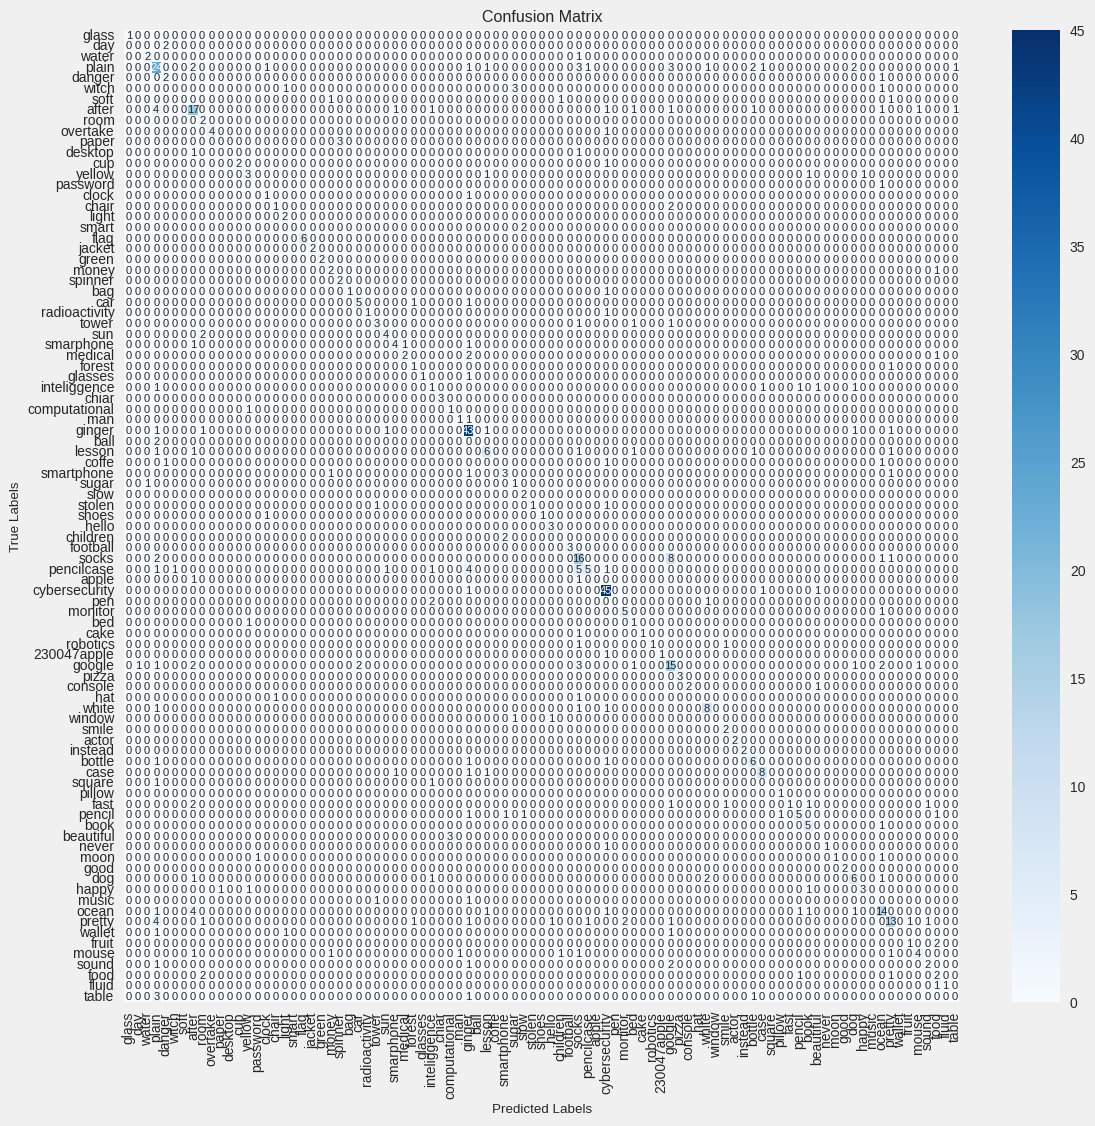

In [132]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
# Replace 'classes' with your actual class labels
classes = allowed_words
# Plot the confusion matrix
plt.style.use("fivethirtyeight")
y_true = true_labels
y_pred = predicted_labels
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/results/confusion_matrix_words_cropped.png')
plt.show()

In [134]:
# Define function to plot loss and accuracy
def plot_metrics1(history):
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(12, 6))
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.tight_layout()
    plt.savefig('/content/gdrive/My Drive/Colab Notebooks/results/word_loss_accuracy_cropped.png')
    plt.show()

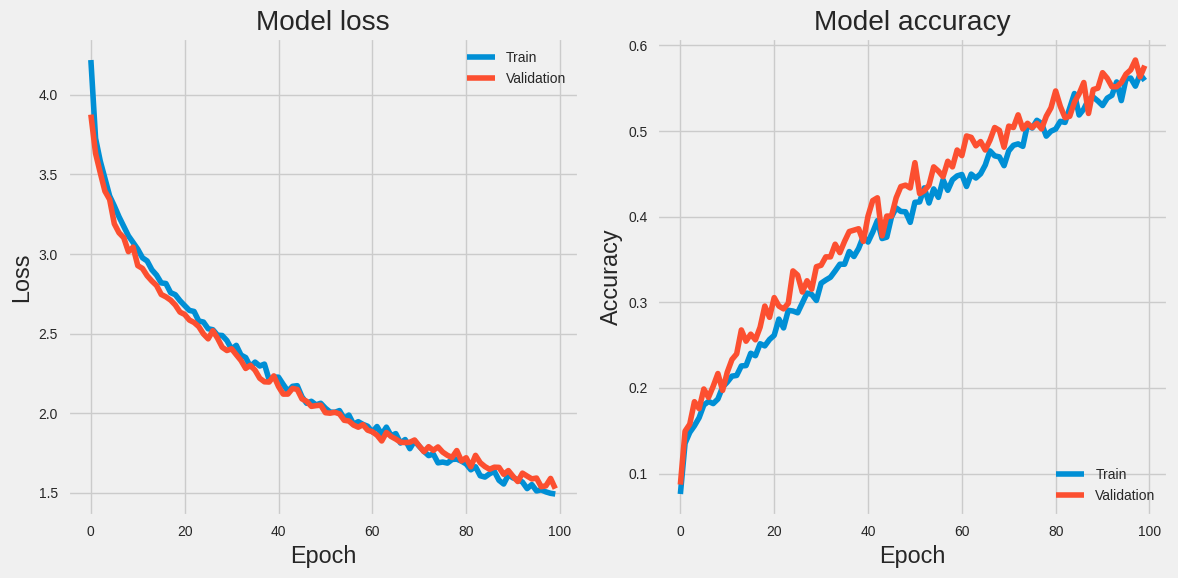

In [135]:
# Plot loss and accuracy
plot_metrics1(history)

In [136]:
# Calculate and print classification report
report = classification_report(true_labels, predicted_labels, target_names=classes)
print("Classification Report:")
print(report)

Classification Report:
               precision    recall  f1-score   support

        glass       1.00      1.00      1.00         1
          day       0.00      0.00      0.00         2
        water       0.67      0.67      0.67         3
        plain       0.48      0.56      0.52        43
       danger       0.40      0.67      0.50         3
        witch       0.00      0.00      0.00         5
         soft       0.00      0.00      0.00         3
        after       0.52      0.57      0.54        30
         room       0.25      1.00      0.40         2
     overtake       1.00      0.80      0.89         5
        paper       0.00      0.00      0.00         3
      desktop       0.00      0.00      0.00         2
          cup       1.00      0.67      0.80         3
       yellow       0.50      0.50      0.50         6
     password       0.00      0.00      0.00         1
        clock       0.33      0.50      0.40         2
        chair       0.50      0.33      0

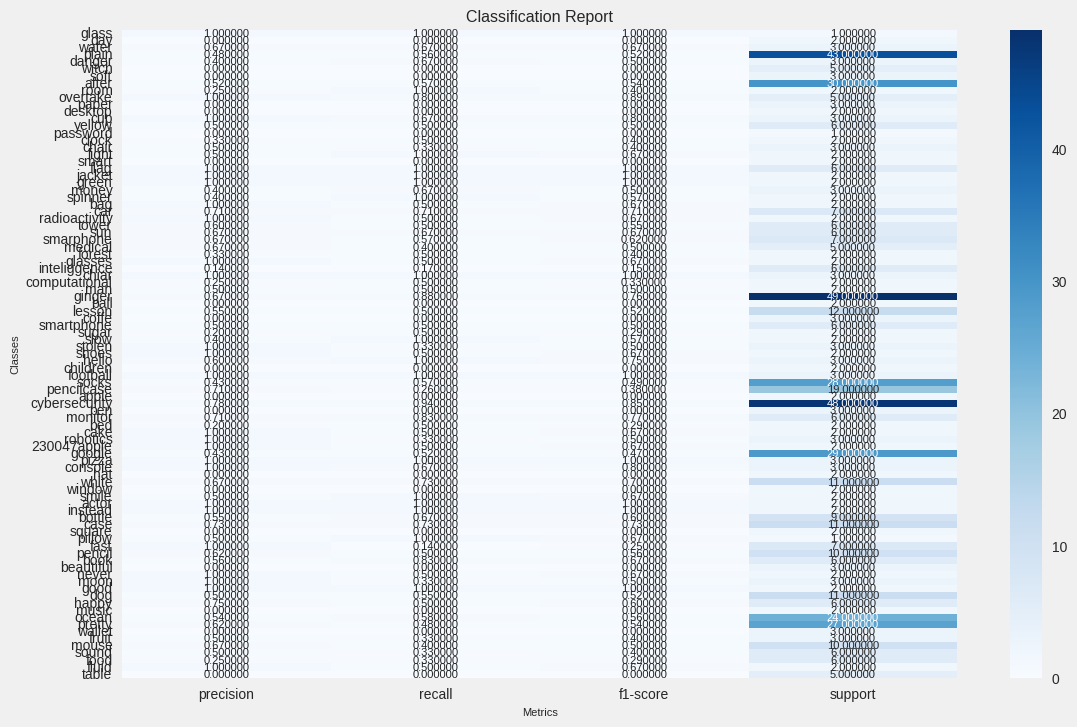

In [137]:
# Create a heatmap-style plot for classification report metrics
def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-5]:
        row = line.split()
        report_data.append(row)

    plt.rcParams.update({'font.size': 8})
    fig, ax = plt.subplots(figsize=(12, 8))
    # Set font size for all characters
    sns.heatmap(np.array(report_data)[:, 1:].astype(float), annot=True, cmap='Blues', fmt='f', xticklabels=['precision', 'recall', 'f1-score', 'support'], yticklabels=classes,  annot_kws={"size": 8})
    plt.xlabel("Metrics", fontsize=8)
    plt.ylabel("Classes", fontsize=8)
    plt.title("Classification Report")
    plt.savefig('/content/gdrive/My Drive/Colab Notebooks/results/classification_words.png')
    plt.show()

# Plot the classification report
plot_classification_report(report)

In [ ]:
## LIPS RECOGNITION

In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 23.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB

In [ ]:
import os
import cv2
import numpy as np
import dlib
import pandas as pd
from skimage import transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv3D, BatchNormalization, Activation, Dropout, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Path to dlib's pre-trained face detector model
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/gdrive/My Drive/Colab Notebooks/shape_predictor_68_face_landmarks.dat')

In [ ]:
def compute_shape_context(points, nbins_r=5, nbins_theta=12, r_inner=0.125, r_outer=2.0):
    """
    Compute the shape context descriptor for a set of points.

    Parameters:
    points (np.ndarray): Array of (x, y) coordinates.
    nbins_r (int): Number of bins for the radial distance.
    nbins_theta (int): Number of bins for the angular distance.
    r_inner (float): Inner radius (as a fraction of the mean distance).
    r_outer (float): Outer radius (as a multiple of the mean distance).

    Returns:
    np.ndarray: Shape context descriptor.
    """
    nsamp = points.shape[0]
    mean_dist = np.mean(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
    r_array = np.linspace(np.log(r_inner), np.log(r_outer), nbins_r)
    r_array = np.exp(r_array)
    theta_array = np.linspace(0, 2*np.pi, nbins_theta + 1)

    descriptor = np.zeros((nsamp, nbins_r * nbins_theta))

    for i in range(nsamp):
        diff = points - points[i, :]
        r = np.sqrt(np.sum(diff**2, axis=1))
        theta = np.arctan2(diff[:, 1], diff[:, 0])
        theta = theta % (2 * np.pi)

        r_bin = np.digitize(r / mean_dist, r_array)
        theta_bin = np.digitize(theta, theta_array)

        hist, _, _ = np.histogram2d(r_bin, theta_bin, bins=[nbins_r, nbins_theta])
        descriptor[i, :] = hist.flatten()

    return descriptor

In [ ]:
def extract_lip_movement_features(video_path):
    """
    Extract lip movement features from a video file using Shape Context.

    Parameters:
    video_path (str): Path to the video file.

    Returns:
    np.ndarray: Extracted lip movement features.
    """
    cap = cv2.VideoCapture(video_path)
    lip_features = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        for face in faces:
            landmarks = predictor(gray, face)
            lips_points = []
            for i in range(48, 68):  # Points corresponding to the lips
                x = landmarks.part(i).x
                y = landmarks.part(i).y
                lips_points.append((x, y))
            lips_points = np.array(lips_points)
            # Compute Shape Context for lip points
            descriptor = compute_shape_context(lips_points)
            lip_features.append(descriptor.flatten())

    cap.release()
    # Convert the list of lip features to a numpy array
    return lip_features

In [ ]:
def pad_features(features, max_length):
    """
    Pad feature vectors to ensure they are of the same length.

    Parameters:
    features (list of np.ndarray): List of feature vectors.
    max_length (int): Length to pad/truncate each feature vector to.

    Returns:
    np.ndarray: Padded feature vectors.
    """
    padded_features = []
    for feature in features:
        if len(feature) > max_length:
            padded_feature = feature[:max_length]
        else:
            padded_feature = np.pad(feature, (0, max_length - len(feature)), 'constant')
        padded_features.append(padded_feature)
    return np.array(padded_features)

In [ ]:
# Directory containing the video data
data_dir = "/content/gdrive/My Drive/Colab Notebooks/dataset"
features_file = '/content/gdrive/My Drive/Colab Notebooks/lips_features.csv'

In [ ]:
if not os.path.exists(features_file):
    lip_features = []
    labels = []

    classes = os.listdir(data_dir)
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print(class_dir)
        if not os.path.isdir(class_dir):
            continue
        for video_file in os.listdir(class_dir):
            video_path = os.path.join(class_dir, video_file)
            features = extract_lip_movement_features(video_path)
            lip_features.extend(features)
            labels.extend([class_name] * len(features))

    # Find the maximum feature length
    max_length = max(len(f) for f in lip_features)

    # Pad features to the same length
    lip_features = pad_features(lip_features, max_length)

    # Save features to a CSV file
    df = pd.DataFrame(lip_features)
    df['label'] = labels
    df.to_csv(features_file, index=False)
else:
    # Load features from the CSV file
    df = pd.read_csv(features_file)
    lip_features = df.iloc[:, :-1].values
    labels = df['label'].values

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pycaret.classification import setup, compare_models, pull, save_model

# Load dataset
csv_file = '/content/gdrive/My Drive/Colab Notebooks/lips_features.csv'
df = pd.read_csv(csv_file)

# Separate features and labels
X = df.iloc[:, :-1].values  # All columns except the last one are features
y = df['label'].values      # The last column is the label

# Set up PyCaret
data = pd.DataFrame(X)
data['label'] = y

# Ensure all feature columns are of type float
data.iloc[:, :-1] = data.iloc[:, :-1].astype(float)

clf_setup = setup(data, target='label', session_id=123, verbose=False)

# Train the model
with tf.device('/GPU:0'):
    models_to_compare = ['lr', 'knn', 'nb', 'dt', 'svm', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'lda', 'et']
    best_model = compare_models(include=models_to_compare)

# Display model comparison results
results = pull()
print(results)

# Save the model comparison results to a CSV file
results.to_csv('/content/gdrive/My Drive/Colab Notebooks/results/lips_model_metric.csv', index=False)

# Save the best model
save_model(best_model, 'best_model_lips')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9439,0.0000,0.9439,0.9450,0.9438,0.9418,0.9419,17.8250
et,Extra Trees Classifier,0.9405,0.9987,0.9405,0.9415,0.9398,0.9384,0.9384,1.6680
mlp,MLP Classifier,0.9396,0.9989,0.9396,0.9414,0.9394,0.9375,0.9375,18.5000
rf,Random Forest Classifier,0.9339,0.9985,0.9339,0.9350,0.9331,0.9315,0.9316,1.2630
svm,SVM - Linear Kernel,0.9084,0.0000,0.9084,0.9185,0.9088,0.9051,0.9054,4.8170
lda,Linear Discriminant Analysis,0.8919,0.0000,0.8919,0.8967,0.8920,0.8880,0.8882,1.1550
ridge,Ridge Classifier,0.8777,0.0000,0.8777,0.8826,0.8754,0.8733,0.8736,0.4330
knn,K Neighbors Classifier,0.8736,0.9789,0.8736,0.8769,0.8721,0.8691,0.8693,1.1040
dt,Decision Tree Classifier,0.8007,0.8968,0.8007,0.8028,0.7998,0.7935,0.7937,0.4770
nb,Naive Bayes,0.5716,0.9511,0.5716,0.6760,0.5625,0.5568,0.5612,0.4540


Processing:   0%|          | 0/53 [00:00<?, ?it/s]

                                 Model  Accuracy     AUC  Recall   Prec.  \
lr                 Logistic Regression    0.9439  0.0000  0.9439  0.9450   
et              Extra Trees Classifier    0.9405  0.9987  0.9405  0.9415   
mlp                     MLP Classifier    0.9396  0.9989  0.9396  0.9414   
rf            Random Forest Classifier    0.9339  0.9985  0.9339  0.9350   
svm                SVM - Linear Kernel    0.9084  0.0000  0.9084  0.9185   
lda       Linear Discriminant Analysis    0.8919  0.0000  0.8919  0.8967   
ridge                 Ridge Classifier    0.8777  0.0000  0.8777  0.8826   
knn             K Neighbors Classifier    0.8736  0.9789  0.8736  0.8769   
dt            Decision Tree Classifier    0.8007  0.8968  0.8007  0.8028   
nb                         Naive Bayes    0.5716  0.9511  0.5716  0.6760   
qda    Quadratic Discriminant Analysis    0.2291  0.0000  0.2291  0.5639   
ada               Ada Boost Classifier    0.1673  0.0000  0.1673  0.1239   

           

(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['0', '1', '2', '3', '4', '5', '6',
                                              '7', '8', '9', '10', '11', '12',
                                              '13', '14', '15', '16', '17', '18',
                                              '19', '20', '21', '22', '23', '24',
                                              '25', '26', '27', '28', '29',...
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                        

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(lip_features, labels_categorical, test_size=0.2, stratify=labels)

In [ ]:
# Reshape the data for the Conv3D layer
X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension
X_test = np.expand_dims(X_test, axis=-1)

In [ ]:
# For Conv3D, we need a 5D tensor: (batch_size, depth, height, width, channels)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], 1, 1)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1, 1)

In [ ]:
# Define a refined Temporal Convolutional Network (TCN) model
def build_tcn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv3D(64, (1, 3, 3), padding='same', kernel_regularizer=l2(0.01), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # Flatten the output to feed into Conv1D layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))

    model.add(Dense(num_classes, activation='softmax'))
    return model

In [ ]:
input_shape = (1, X_train.shape[2], 1, 1)
num_classes = len(np.unique(labels))

In [ ]:
np.unique(labels)

array(['Adriano', 'Albert', 'Alessandra', 'Alex', 'Andrea', 'AndreaG',
       'Cantarella', 'Cristian', 'Davide', 'Edoardo', 'Emilio', 'Ernesto',
       'Fabio', 'Francesca', 'Iris', 'Jacopo', 'Luca', 'Mansueto',
       'Mattia', 'Rachele', 'Sabrina', 'Simone', 'SimoneO', 'Siria',
       'SiriaI', 'Solenne', 'Sophia', 'Stefano', 'StefanoM', 'Vincenzo'],
      dtype=object)

In [ ]:
model = build_tcn_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 1, 1200, 1, 64)    640       
                                                                 
 batch_normalization (Batch  (None, 1, 1200, 1, 64)    256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 1, 1200, 1, 64)    0         
                                                                 
 dropout (Dropout)           (None, 1, 1200, 1, 64)    0         
                                                                 
 flatten (Flatten)           (None, 76800)             0         
                                                                 
 dense (Dense)               (None, 256)               19661056  
                                                        

In [ ]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Early stopping and model checkpoint
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/results/lips_best_model.h5', monitor='val_loss', save_best_only=True)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=[reduce_lr, early_stopping])

NameError: name 'model' is not defined

In [ ]:
# Plot the loss and accuracy
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.tight_layout()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/results/loss_accuracy_lips_shape_context.png')
plt.show()

In [ ]:
# Save the model
from tensorflow.keras.models import save_model
save_model(model, '/content/gdrive/My Drive/Colab Notebooks/results/tcn_model_lips_shape_context.h5')  # Save in format h5

<ipython-input-22-c9693ff50bbc>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, '/content/gdrive/My Drive/Colab Notebooks/results/tcn_model_lips_shape_context.h5')  # Save in format h5


In [ ]:
# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.4f}%")

500/500 [==============================] - 2s 3ms/step - loss: 0.7725 - accuracy: 0.8582
Train Loss: 0.7725, Train Accuracy: 85.8198%


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.4f}%")

125/125 [==============================] - 0s 3ms/step - loss: 0.8087 - accuracy: 0.8506
Test Loss: 0.8087, Test Accuracy: 85.0601%


In [ ]:
predictions = model.predict(X_test)
true_labels = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded
predicted_labels = np.argmax(predictions, axis=1)

125/125 [==============================] - 0s 2ms/step


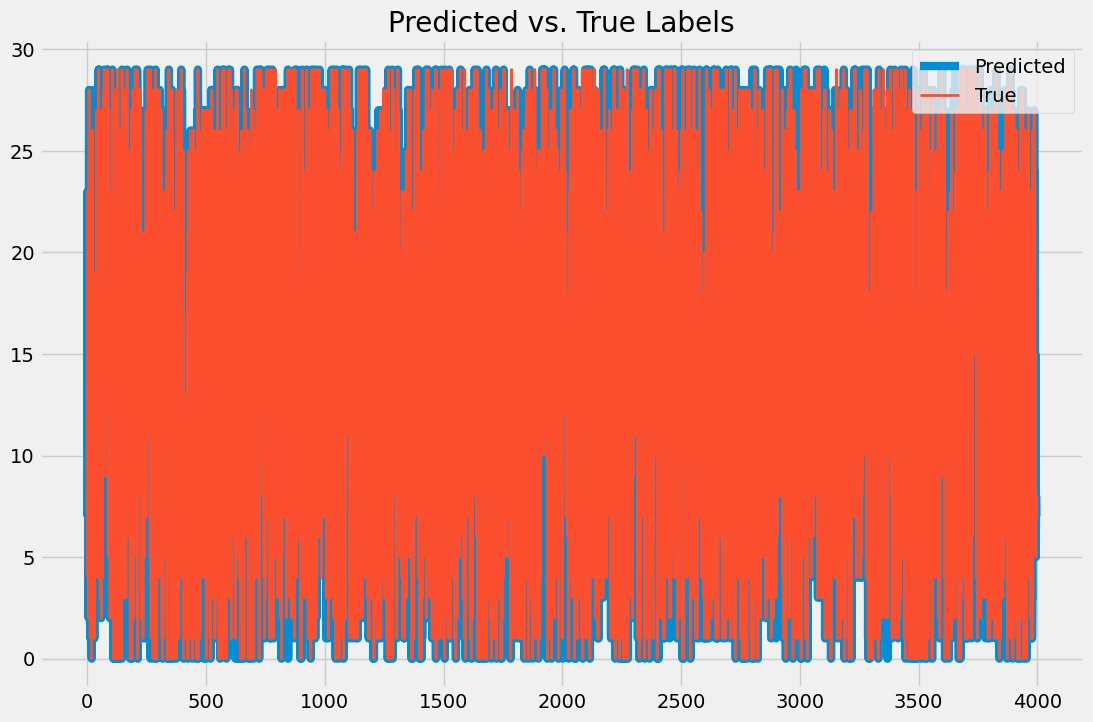

In [ ]:
# Create a bar plot to visualize predicted vs. true labels
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 8))
plt.plot(predicted_labels, label='Predicted', linewidth = '6.0')
plt.plot(true_labels, label='True', linewidth = '2.0')
plt.title('Predicted vs. True Labels')
plt.legend()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/results/inference_curve_zoom_lips_shape_context.png')
plt.show()

In [ ]:
# Ensure your `classes` list matches the unique class labels
#classes = ['Adriano', 'Albert', 'Alessandra', 'Alex', 'Andrea', 'AndreaG', 'Cantarella', 'Cristian', 'Davide', 'Edoardo', 'Emilio', 'Ernesto', 'Fabio', 'Francesca', 'Iris', 'Jacopo', 'Luca', 'Mansueto', 'Mattia', 'Rachele', 'Sabrina', 'Simone', 'SimoneO', 'Siria', 'SiriaI', 'Solenne', 'Sophia', 'Stefano', 'StefanoM', 'Vincenzo']
classes = np.unique(labels)
# Ensure the number of unique labels matches the number of classes
unique_labels = np.unique(true_labels)
if len(unique_labels) != len(classes):
    print(f"Warning: Number of unique labels ({len(unique_labels)}) does not match number of classes ({len(classes)})")

In [ ]:
import sklearn

# Calculate the confusion matrix
conf_matrix = sklearn.metrics.confusion_matrix(true_labels, predicted_labels)

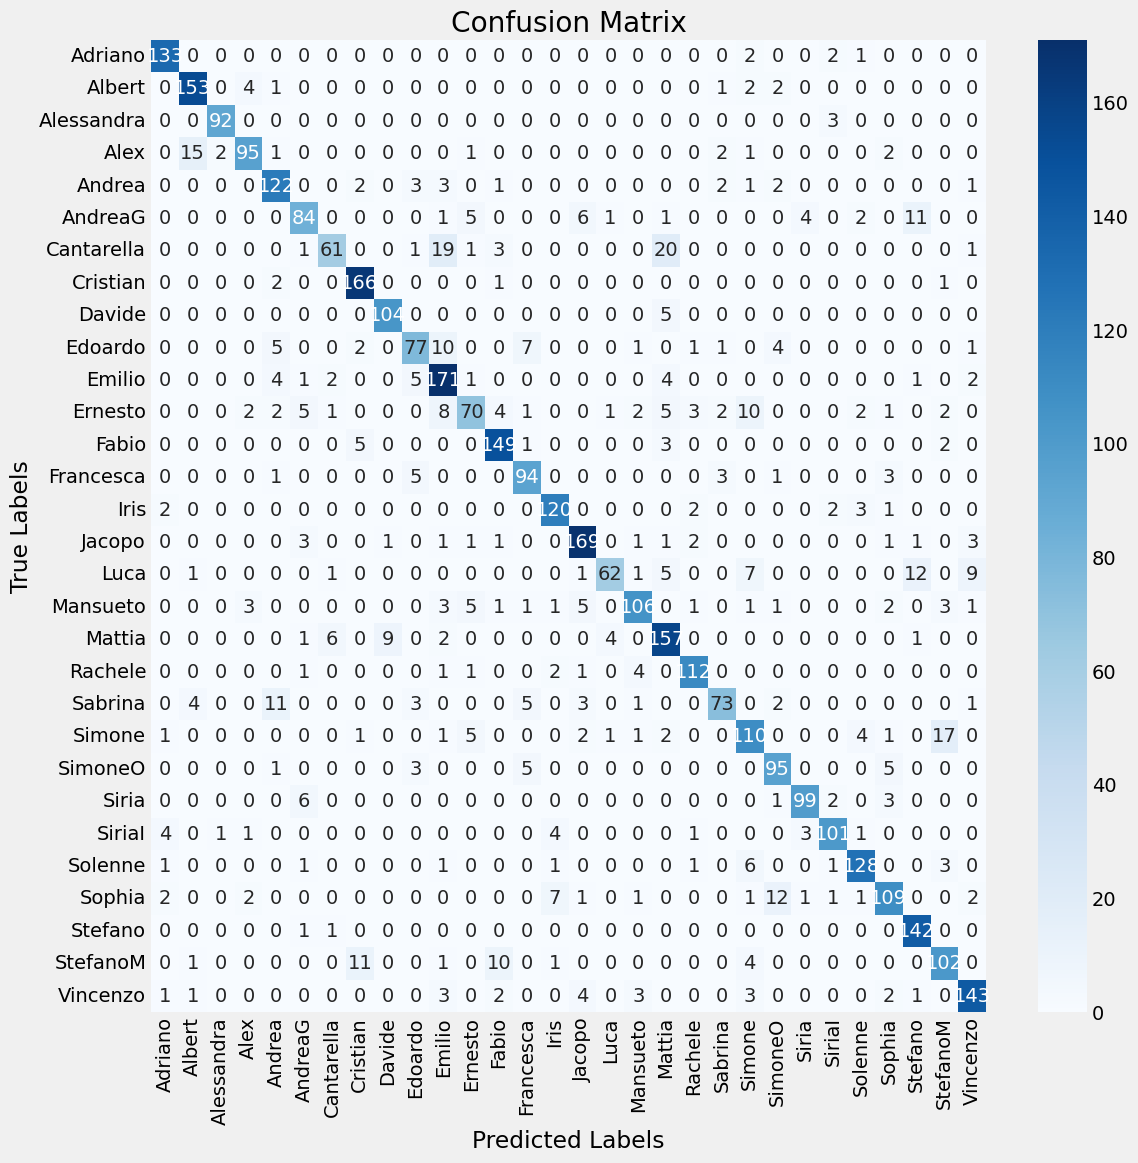

In [ ]:
# Plot the confusion matrix
plt.style.use("fivethirtyeight")
y_true = true_labels
y_pred = predicted_labels
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/results/confusion_matrix_lips_shape_context.png')
plt.show()

In [ ]:
## VOICE RECOGNITION

In [ ]:
!pip install resampy
!pip install llvmlite
!pip install librosa
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.1 MB/s eta 0:00:00


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jul 11 13:45:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import pandas as pd
import os
import librosa as librs
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
import wave
import matplotlib.pylab as pyl
import soundfile as sf
import tensorflow as tf
import resampy
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Conv1D, Activation, BatchNormalization, SpatialDropout1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
my_duration = 10

In [ ]:
# Augmentation function
def augment_audio(audio, sr):
    augmented_audios = []
    augmented_audios.append(librs.effects.time_stretch(audio, rate=0.8))
    augmented_audios.append(librs.effects.time_stretch(audio, rate=1.2))
    augmented_audios.append(librs.effects.pitch_shift(y=audio, sr=sr, n_steps=-2))
    augmented_audios.append(librs.effects.pitch_shift(y=audio, sr=sr, n_steps=2))
    noise = np.random.randn(len(audio))
    augmented_audios.append(audio + 0.005 * noise)
    return augmented_audios

In [ ]:
# Feature extraction function
def extract_audio_features(file_path, sample_rate=22050, num_mels=128, duration=10):
    y, sr = librs.load(file_path, sr=sample_rate, duration=duration)
    mel_spectrogram = librs.feature.melspectrogram(y=y, sr=sr, n_mels=num_mels)
    mel_spectrogram_db = librs.power_to_db(mel_spectrogram, ref=np.max)
    mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, max(0, 128 - mel_spectrogram_db.shape[1]))), mode='constant')[:, :128]

    augmented_audios = augment_audio(y, sr)
    features = [mel_spectrogram_db]
    for augmented_audio in augmented_audios:
        mel_spectrogram = librs.feature.melspectrogram(y=augmented_audio, sr=sr, n_mels=128)
        mel_spectrogram_db = librs.power_to_db(mel_spectrogram, ref=np.max)
        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, max(0, 128 - mel_spectrogram_db.shape[1]))), mode='constant')[:, :128]
        features.append(mel_spectrogram_db)
    return features

In [ ]:
# Preprocessing function
def preprocess_audio_dataset(data_dir, sample_rate=22050, num_mels=128, duration=10):
    voice_features = []
    labels = []
    classes = os.listdir(data_dir)
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print(class_dir)
        if not os.path.isdir(class_dir):
            continue
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            features = extract_audio_features(file_path, sample_rate=sample_rate, num_mels=num_mels, duration=duration)
            voice_features.extend(features)
            labels.extend([class_name] * len(features))
    return np.array(voice_features), np.array(labels)

In [ ]:
# Load dataset
csv_file = '/content/gdrive/My Drive/Colab Notebooks/voice_features_augmented.csv'
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
    voice_features = np.array(df['features'].apply(eval).tolist())  # Convert list back to numpy array
    labels = np.array(df['labels'].tolist())
else:
    data_dir = "/content/gdrive/My Drive/Colab Notebooks/output"
    voice_features, labels = preprocess_audio_dataset(data_dir)
    df = pd.DataFrame({
        'features': [feat.tolist() for feat in voice_features],  # Convert numpy arrays to lists for serialization
        'labels': labels
    })
    df.to_csv(csv_file, index=False)

In [ ]:
# Showing the fist lines of our csv file with the list of all augmented clicks
metadata1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/voice_features_augmented.csv')
metadata1.head(10)

,features,labels
0,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",AndreaG
1,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",AndreaG
2,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",AndreaG
3,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",AndreaG
4,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",AndreaG
5,"[[-52.76082550062013, -51.74707768306804, -48....",AndreaG
6,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",AndreaG
7,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",AndreaG
8,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",AndreaG
9,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",AndreaG


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(voice_features, labels_categorical, test_size=0.2, stratify=labels)

In [ ]:
# Model definition
def build_tcn(input_shape, num_classes, num_filters=128, kernel_size=3, num_layers=4, dropout_rate=0.2):
    inputs = Input(shape=input_shape)
    x = inputs
    for i in range(num_layers):
        dilation_rate = 2 ** i
        x = Conv1D(filters=num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv3D, BatchNormalization, Activation, Dropout, Flatten
from tensorflow.keras.regularizers import l2

In [ ]:
# Build and compile model
input_shape = (128, 128)
num_classes = len(np.unique(labels))
tcn_model = build_tcn(input_shape, num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
tcn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
np.unique(labels)

array(['Adriano', 'Albert', 'Alessandra', 'Alex', 'Andrea', 'AndreaG',
       'Cantarella', 'Cristian', 'Davide', 'Edoardo', 'Emilio', 'Ernesto',
       'Fabio', 'Francesca', 'Iris', 'Jacopo', 'Luca', 'Mansueto',
       'Mattia', 'Rachele', 'Sabrina', 'Simone', 'SimoneO', 'Siria',
       'SiriaI', 'Solenne', 'Sophia', 'Stefano', 'StefanoM', 'Vincenzo'],
      dtype='<U10')

In [ ]:
len(np.unique(labels))

30

In [ ]:
tcn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128)]        0         
                                                                 
 conv1d (Conv1D)             (None, 128, 128)          49280     
                                                                 
 batch_normalization (Batch  (None, 128, 128)          512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128, 128)          0         
                                                                 
 spatial_dropout1d (Spatial  (None, 128, 128)          0         
 Dropout1D)                                                      
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 128)          49280 

In [ ]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Early stopping and model checkpoint
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/results/voices_best_model.h5', monitor='val_loss', save_best_only=True)

In [ ]:
# Train model
history = tcn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
117/117 [==============================] - 9s 13ms/step - loss: 3.3427 - accuracy: 0.0807 - val_loss: 3.5026 - val_accuracy: 0.0962 - lr: 0.0010
Epoch 2/100
117/117 [==============================] - 1s 8ms/step - loss: 3.0514 - accuracy: 0.1223 - val_loss: 3.0576 - val_accuracy: 0.1154 - lr: 0.0010
Epoch 3/100
117/117 [==============================] - 1s 8ms/step - loss: 2.9064 - accuracy: 0.1458 - val_loss: 3.6641 - val_accuracy: 0.1303 - lr: 0.0010
Epoch 4/100
117/117 [==============================] - 1s 8ms/step - loss: 2.8362 - accuracy: 0.1512 - val_loss: 2.9164 - val_accuracy: 0.1474 - lr: 0.0010
Epoch 5/100
117/117 [==============================] - 1s 7ms/step - loss: 2.7116 - accuracy: 0.1864 - val_loss: 2.7811 - val_accuracy: 0.1624 - lr: 0.0010
Epoch 6/100
117/117 [==============================] - 1s 8ms/step - loss: 2.6557 - accuracy: 0.2094 - val_loss: 2.9716 - val_accuracy: 0.1581 - lr: 0.0010
Epoch 7/100
117/117 [==============================] - 1s 8ms/s

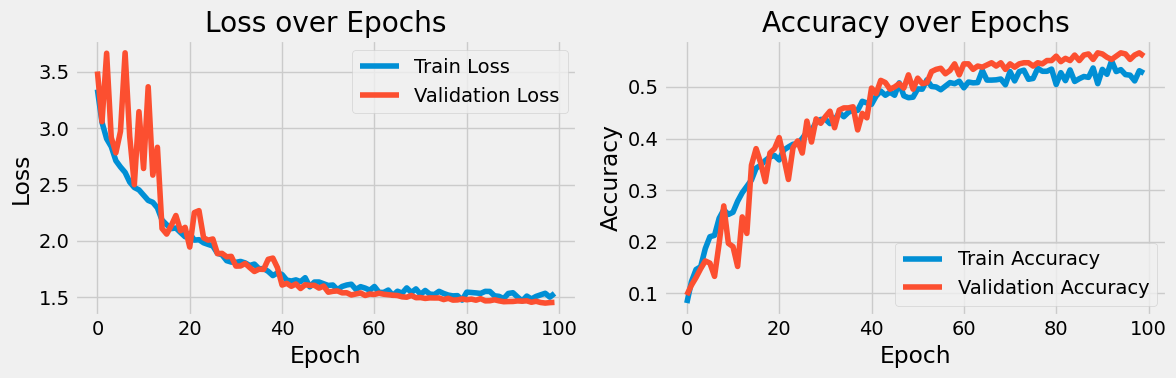

In [ ]:
# Plot the loss and accuracy
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.tight_layout()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/results/loss_accuracy_voice.png')
plt.show()

In [ ]:
!pip install pycaret gradio pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 M

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jul 11 14:00:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0              28W /  70W |    383MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import tensorflow as tf

# Verify GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TensorFlow")

Num GPUs Available:  1
Default GPU Device: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from pycaret.classification import setup, compare_models, pull, save_model, load_model
import gradio as gr

# Load dataset
csv_file = '/content/gdrive/My Drive/Colab Notebooks/voice_features_augmented.csv'
df = pd.read_csv(csv_file)
X = np.array(df['features'].apply(eval).tolist())  # Convert list back to numpy array
y = df['labels']

# Convert X into a DataFrame and flatten each spectrogram (from 2D to 1D)
num_samples, num_mels, num_timesteps = X.shape
X_flattened = X.reshape(num_samples, num_mels * num_timesteps)
df_features = pd.DataFrame(X_flattened)
df_labels = pd.Series(y, name='label')

# Create a DataFrame suitable for PyCaret
data = pd.concat([df_features, df_labels], axis=1)

# Set up PyCaret
clf_setup = setup(data, target='label', session_id=123, verbose=False)

# Train the model
with tf.device('/GPU:0'):
  # Compare models
  #best_model = compare_models()
  # Compare all models
  models_to_compare = ['lr', 'knn', 'nb', 'dt', 'svm', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'lda', 'et']
  best_model = compare_models(include=models_to_compare)

# Display model comparison results
results = pull()
print(results)
# Save the model comparison results to a CSV file
results.to_csv('/content/gdrive/My Drive/Colab Notebooks/results/voice_model_metric.csv', index=False)

# Save the best model
save_model(best_model, 'best_model_voice')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7466,0.0000,0.7466,0.7799,0.7430,0.7378,0.7392,12.5590
lr,Logistic Regression,0.6917,0.0000,0.6917,0.7246,0.6850,0.6810,0.6825,38.5830
ridge,Ridge Classifier,0.6715,0.0000,0.6715,0.7034,0.6645,0.6601,0.6616,4.5230
et,Extra Trees Classifier,0.6294,0.9361,0.6294,0.6611,0.6174,0.6166,0.6183,7.1310
rf,Random Forest Classifier,0.6233,0.9447,0.6233,0.6578,0.6077,0.6103,0.6123,14.7520
svm,SVM - Linear Kernel,0.4316,0.0000,0.4316,0.5161,0.4050,0.4119,0.4244,33.4940
knn,K Neighbors Classifier,0.3077,0.7871,0.3077,0.3382,0.2978,0.2838,0.2854,4.1510
dt,Decision Tree Classifier,0.2766,0.6258,0.2766,0.3043,0.2718,0.2516,0.2526,25.1050
ada,Ada Boost Classifier,0.1075,0.0000,0.1075,0.0628,0.0553,0.0773,0.0857,107.4760
nb,Naive Bayes,0.0580,0.5162,0.0580,0.0359,0.0273,0.0262,0.0311,4.2530


Processing:   0%|          | 0/53 [00:00<?, ?it/s]

                                 Model  Accuracy     AUC  Recall   Prec.  \
lda       Linear Discriminant Analysis    0.7466  0.0000  0.7466  0.7799   
lr                 Logistic Regression    0.6917  0.0000  0.6917  0.7246   
ridge                 Ridge Classifier    0.6715  0.0000  0.6715  0.7034   
et              Extra Trees Classifier    0.6294  0.9361  0.6294  0.6611   
rf            Random Forest Classifier    0.6233  0.9447  0.6233  0.6578   
svm                SVM - Linear Kernel    0.4316  0.0000  0.4316  0.5161   
knn             K Neighbors Classifier    0.3077  0.7871  0.3077  0.3382   
dt            Decision Tree Classifier    0.2766  0.6258  0.2766  0.3043   
ada               Ada Boost Classifier    0.1075  0.0000  0.1075  0.0628   
nb                         Naive Bayes    0.0580  0.5162  0.0580  0.0359   
qda    Quadratic Discriminant Analysis    0.0507  0.0000  0.0507  0.0518   
mlp                     MLP Classifier    0.0330  0.4997  0.0330  0.0011   

           

(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['0', '1', '2', '3', '4', '5', '6',
                                              '7', '8', '9', '10', '11', '12',
                                              '13', '14', '15', '16', '17', '18',
                                              '19', '20', '21', '22', '23', '24',
                                              '25', '26', '27', '28', '29',...
                  TransformerWrapper(exclude=None, include=[],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                        

In [ ]:
# Define the prediction function for Gradio
def predict(input_data):
    model = load_model('best_model')
    input_df = pd.DataFrame([input_data])
    prediction = model.predict(input_df)
    return prediction[0]

# Create Gradio interface
input_components = [gr.Dataframe(headers=[f'feature_{i}' for i in range(num_mels * num_timesteps)], row_count=1)]
output_component = gr.Textbox(label="Prediction")

interface = gr.Interface(fn=predict, inputs=input_components, outputs=output_component, title="Voice Classification")

# Launch the Gradio app
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c922ec83c8f684cc5c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
